In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d, correlate
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

In [8]:
# Scipy version
def wiener(im, mysize=None, noise=None):
    """
    Perform a Wiener filter on an N-dimensional array.

    Apply a Wiener filter to the N-dimensional array `im`.

    Parameters
    ----------
    im : ndarray
        An N-dimensional array.
    mysize : int or array_like, optional
        A scalar or an N-length list giving the size of the Wiener filter
        window in each dimension.  Elements of mysize should be odd.
        If mysize is a scalar, then this scalar is used as the size
        in each dimension.
    noise : float, optional
        The noise-power to use. If None, then noise is estimated as the
        average of the local variance of the input.

    Returns
    -------
    out : ndarray
        Wiener filtered result with the same shape as `im`.

    Notes
    -----
    This implementation is similar to wiener2 in Matlab/Octave.
    For more details see [1]_

    References
    ----------
    .. [1] Lim, Jae S., Two-Dimensional Signal and Image Processing,
           Englewood Cliffs, NJ, Prentice Hall, 1990, p. 548.

    Examples
    --------
    >>> from scipy.datasets import face
    >>> from scipy.signal import wiener
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> rng = np.random.default_rng()
    >>> img = rng.random((40, 40))    #Create a random image
    >>> filtered_img = wiener(img, (5, 5))  #Filter the image
    >>> f, (plot1, plot2) = plt.subplots(1, 2)
    >>> plot1.imshow(img)
    >>> plot2.imshow(filtered_img)
    >>> plt.show()

    """
    im = np.asarray(im)
    if mysize is None:
        mysize = [3] * im.ndim
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.prod(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') /
            np.prod(mysize, axis=0) - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

In [73]:
def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [119]:
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    gauss = gauss / np.max(np.abs(gauss))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy

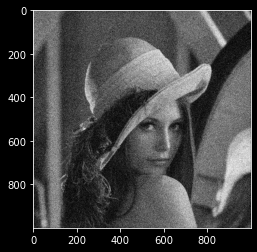

In [121]:
original_image = io.imread('data/lena.jpg')
original_image = color.rgb2gray(original_image)

blurred_img = blur(original_image, kernel_size=3)
noisy_image = add_gaussian_noise(blurred_img, sigma=30)

plt.imshow(noisy_image, cmap='gray')
# noisy_image = util.random_noise(original_image, mode='gaussian', var=0.3, mean=-0.3)

In [128]:
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
our_image = wiener_filter(noisy_image, gaussian_kernel(5), K=10)

/tmp/ipykernel_6419/2116142732.py:70: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/tmp/ipykernel_6419/2116142732.py:70: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


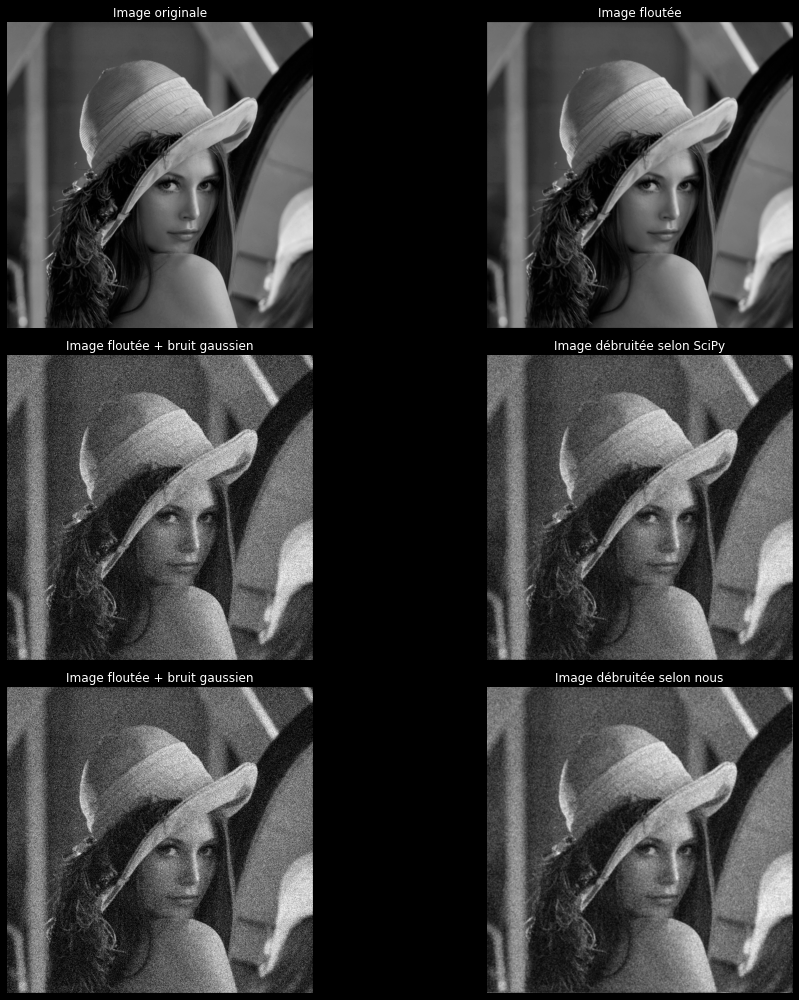

In [129]:
import matplotlib.pyplot as plt

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))

# Liste des noms de fichiers d'images
image_files = [original_image, blurred_img, noisy_image, scipy_image, noisy_image, our_image]

# Liste des titres pour chaque image
image_titles = ['Image originale', 'Image floutée', 'Image floutée + bruit gaussien',
                'Image débruitée selon SciPy', 'Image floutée + bruit gaussien',
                'Image débruitée selon nous']

for i, ax in enumerate(axes.flat):
    if i >= len(image_files):
        break
    ax.imshow(image_files[i], cmap='gray')
    ax.set_title(image_titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [127]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_us = peak_signal_noise_ratio(original_image, our_image)
print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_us)

PSNR from SciPy: 23.518493962688748
PSNR from us: 9.190980100592887
